# ANOVA for continuous variable feature selection


Anova provides a comparison of the means of two groups.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile



In [14]:
data = 'pulsar_data_train.csv'
df = pd.read_csv(data)
df.columns = df.columns.str.strip()
df = df.dropna()

X_train = df.iloc[:, :-1]
y_train = df["target_class"]

print(X_train)


       Mean of the integrated profile  \
0                          121.156250   
1                           76.968750   
2                          130.585938   
4                           84.804688   
7                          109.406250   
...                               ...   
12522                      124.828125   
12523                      124.312500   
12525                      116.031250   
12526                      135.664062   
12527                      120.726562   

       Standard deviation of the integrated profile  \
0                                         48.372971   
1                                         36.175557   
2                                         53.229534   
4                                         36.117659   
7                                         55.912521   
...                                             ...   
12522                                     50.586731   
12523                                     53.179053   
12525       

# Initial data pruning.
Much like from the feature selection book, we will remove any constant, quasi constant, and correlated features from our featureset


In [25]:
const_feature = VarianceThreshold(threshold=0.01)
const_feature.fit(X_train, y_train)

X_train_new = const_feature.transform(X_train)
#now compare the two feature sets
print(X_train.shape)
print(X_train_new.shape)

#there are no quasi constant or constant features in the dataset


(9273, 8)
(9273, 8)


In [22]:
X_train.duplicated().sum()
#no duplicate rows
#can grab index of duplicated features if we use
# dup = X_train.duplicated()
# features_to_keep = [for index for index in dup]

#this gives us a list of feautres for which they are unique. can be grabbed 
#from dataframe

0

### Applying the F-test : ANOVA


In [27]:
fscore, pvalue = f_classif(X_train_new, y_train)
print(fscore)
print(pvalue)

[ 7794.21864257  1454.21624065 15482.64597577  9148.07850795
  1841.09440076  2979.42155187  1666.61111384   663.47197755]
[0.00000000e+000 1.04699406e-295 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.26971319e-141]


well this data is not good for this, so getting a new data set

In [31]:
df = pd.read_csv("pima-indians-diabetes.csv")
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Initial Pruning... Again


In [53]:
const_feature = VarianceThreshold(threshold=0.01)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                   df["class"], test_size=0.33, random_state=1)
const_feature.fit(X_train, y_train)
X_train_new = const_feature.transform(X_train)

print(X_train.shape)
print(X_train_new.shape)

(514, 8)
(514, 8)


Again, no features are eliminated from the original screening


In [54]:
fscore, pvalue = f_classif(X_train_new, y_train)
pvalue = pd.Series(pvalue)
pvalue.index = df.drop(columns=["class"]).columns
print(fscore)
print(pvalue.sort_values(ascending=True))

[1.65273845e+01 1.31325562e+02 4.23711464e-02 1.41521551e+00
 1.27789661e+01 4.92095231e+01 1.33771423e+01 2.51264397e+01]
glucose                     3.189502e-27
bmi                         7.317218e-12
age                         7.409770e-07
pregnancies                 5.549782e-05
diabetespedigreefunction    2.810699e-04
insulin                     3.837293e-04
skinthickness               2.347439e-01
bloodpressure               8.369957e-01
dtype: float64


Now writing a KNN classifier, lets see if the anova analysis of the features yields  better results when we take the k best features

In [55]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_train_new, y_train)

print(f"The initial score with the original feature set: {clf.score(X_test, y_test)}")

#now lets use the 3 best features
df_new = df[["glucose", "bmi", "age", "class"]]
X_train, X_test, y_train, y_test = train_test_split(df_new.iloc[:, :-1],
                                                   df["class"], test_size=0.33, random_state=1)
clf.fit(X_train, y_train)
print(f"The initial score with the original feature set: {clf.score(X_test, y_test)}")

The initial score with the original feature set: 0.7677165354330708
The initial score with the original feature set: 0.7637795275590551


We are seeing this is not making a result. lets try and engineer the features.
Our tuning will use a grid search cross valdiation algorithm, and the number of features selected with be compared against the models accuracy

Best Mean Accuracy: 0.766
Best Configuration: {'anova__k': 7}
>1 0.732 (0.045)
>2 0.752 (0.045)
>3 0.761 (0.043)
>4 0.747 (0.042)
>5 0.749 (0.037)
>6 0.752 (0.037)
>7 0.761 (0.034)
>8 0.757 (0.037)


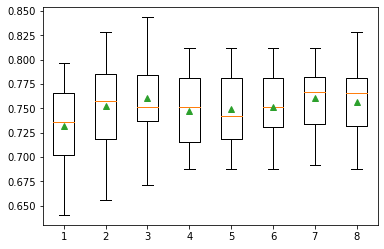

In [70]:
# compare different numbers of features selected using anova f-test
from pandas import read_csv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from numpy import mean
from numpy import std

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                   df["class"], test_size=0.33, random_state=1)


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LogisticRegression(solver="liblinear")
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova', fs), ('lr', model)])

#create the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X_train.shape[1])]

#define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
results = search.fit(X_train, y_train)
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Configuration: %s' % results.best_params_)

#lets produce someboxplots with these
results = []
num_features = [i+1 for i in range(X_train.shape[1])]
for k in range(X_train.shape[1]):
    model = LogisticRegression(solver="liblinear")
    fs = SelectKBest(score_func=f_classif, k=k+1)
    pipeline = Pipeline(steps=[('anova', fs), ('lr', model)])
    
    cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print('>%d %.3f (%.3f)' % (k+1, mean(scores), std(scores)))
    results.append(scores)

pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()
    
    
    